###### This project is multiclass classification because the model must choose one of 15 animal classes (Bear, Bird, Cat, … Zebra). Multiclass = more than 2 classes.

# Importing Libraries

In [3]:
# Operating system library for handling files and directories
import os  

# Numerical computing library for handling arrays and mathematical operations
import numpy as np  

# TensorFlow library for building and training machine learning models
import tensorflow as tf  

# Importing layers module to create neural network layers
from tensorflow.keras import layers  

# Utility to load and preprocess images, and generate augmented image batches
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator  

# Sequential model allows us to build neural networks layer by layer
from tensorflow.keras.models import Sequential, load_model  

# Importing specific layers for building CNNs (Convolutional Neural Networks)
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten , Input

# Count the number of images in each dataset folder

In [5]:
total_images = 0  # This will keep track of all images in the dataset

# Go through each class folder inside the main 'dataset' folder
for folder in os.listdir('dataset/'):
    # Count how many images are in this class folder
    num_files = len(os.listdir(os.path.join('dataset/', folder)))
    
    # Print a message showing how many images are in this class
    print(f"Folder '{folder}' contains {num_files} images")
    
    # Add this folder's images to the total count
    total_images += num_files

# Print the total number of images across all classes
print(f"The dataset has a total of {total_images} images")

Folder 'Bear' contains 125 images
Folder 'Bird' contains 137 images
Folder 'Cat' contains 123 images
Folder 'Cow' contains 131 images
Folder 'Deer' contains 127 images
Folder 'Dog' contains 122 images
Folder 'Dolphin' contains 129 images
Folder 'Elephant' contains 133 images
Folder 'Giraffe' contains 129 images
Folder 'Horse' contains 130 images
Folder 'Kangaroo' contains 126 images
Folder 'Lion' contains 131 images
Folder 'Panda' contains 135 images
Folder 'Tiger' contains 129 images
Folder 'Zebra' contains 137 images
The dataset has a total of 1944 images


# Convert images from folders into arrays for training


In [7]:
# Path to the main dataset folder
base_dir = 'dataset/'

# Resize all images to 180x180 pixels for consistency
img_size = 180

# Number of images processed together in one batch during training
batch = 32

In [8]:
# Load training dataset: images are read from folders, resized, and batched
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,                 # Main folder containing subfolders for each class
    validation_split=0.2,     # Reserve 20% of images for validation
    subset='training',        # Use this split for training
    seed=123,                 # Ensures the split is consistent every run
    batch_size=batch,          # Number of images processed together
    image_size=(img_size, img_size)  # Resize all images to same size
)

# Load validation dataset using the same split and settings
val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset='validation',       # Use this split for validation
    seed=123,
    batch_size=batch,
    image_size=(img_size, img_size)
)

Found 1944 files belonging to 15 classes.
Using 1556 files for training.
Found 1944 files belonging to 15 classes.
Using 388 files for validation.


# Animal names

In [10]:
animal_names = train_ds.class_names
animal_names

['Bear',
 'Bird',
 'Cat',
 'Cow',
 'Deer',
 'Dog',
 'Dolphin',
 'Elephant',
 'Giraffe',
 'Horse',
 'Kangaroo',
 'Lion',
 'Panda',
 'Tiger',
 'Zebra']

# Display a small sample of images from the training dataset

In [12]:
import matplotlib.pyplot as plt  # Import matplotlib to create plots and show images

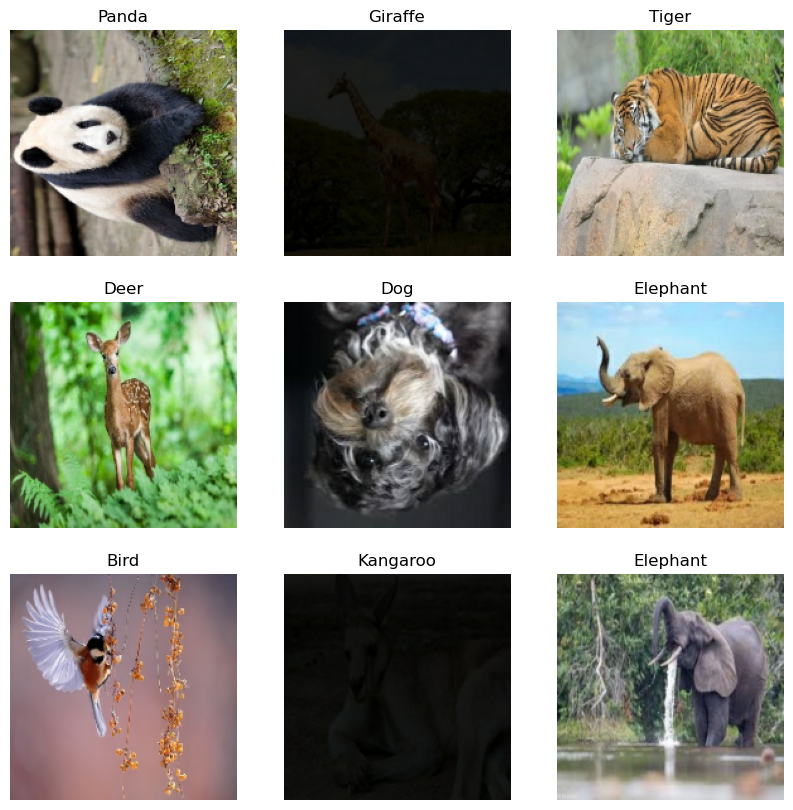

In [13]:
plt.figure(figsize=(10, 10))  # Create a big figure to show images clearly

# Take one batch of images from the training dataset
for images, labels in train_ds.take(1):
    for i in range(9):  # Show 9 images from this batch
        plt.subplot(3, 3, i + 1)  # Arrange images in a 3x3 grid
        plt.imshow(images[i].numpy().astype('uint8'))  # Convert tensor to displayable image
        plt.title(animal_names[labels[i]])  # Show the class name as the title
        plt.axis('off')  # Hide axes for a cleaner look

# Optimize Dataset Loading for Faster Training

In [15]:
AUTOTUNE = tf.data.AUTOTUNE  # Let TensorFlow choose the best way to load data efficiently

In [16]:
# Optimize the training dataset
train_ds = train_ds.cache()                     # Keep data in memory after first use
train_ds = train_ds.shuffle(1000)               # Shuffle to prevent learning order bias
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)  # Load batches in the background

In [17]:
# Optimize the validation dataset
val_ds = val_ds.cache()                         # Keep data in memory after first use
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE) # Load batches in the background

# Data Augmentation

In [19]:
data_augmentation = Sequential([
    Input(shape=(img_size, img_size, 3)),    # Define the input shape here
    layers.RandomFlip("horizontal"),         # Randomly flip left-right
    layers.RandomRotation(0.1),              # Rotate up to 10%
    layers.RandomZoom(0.1),                   # Zoom up to 10%
    layers.GaussianNoise(0.05),
    layers.RandomContrast(0.2)
])

# Visualizing Sample Augmented Images

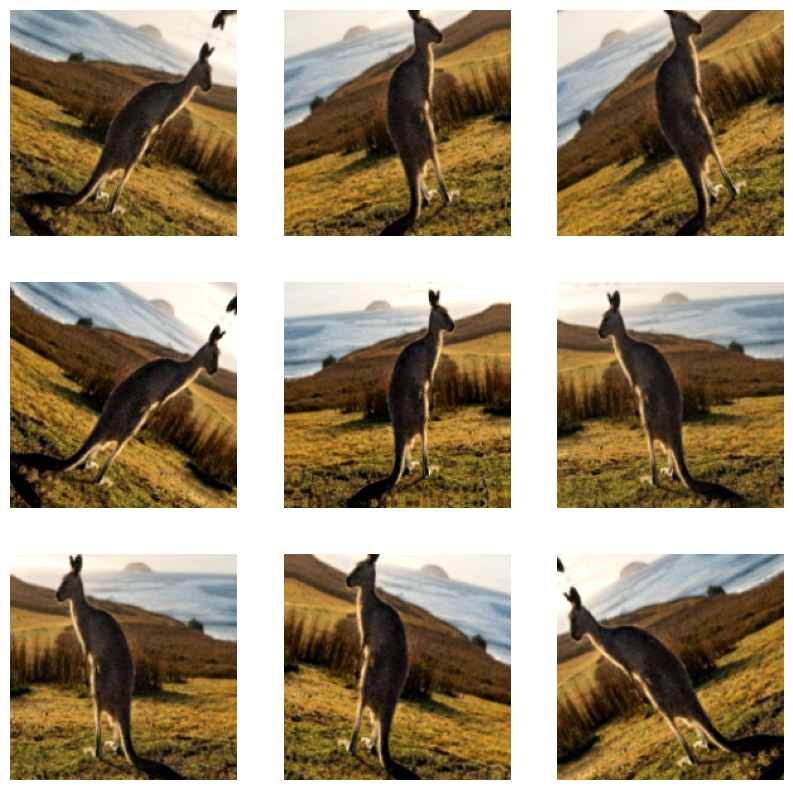

In [21]:
plt.figure(figsize=(10,10))  # Create a large 10x10 figure for displaying images

# Take one batch of images from the training dataset
for images, labels in train_ds.take(1):
    
    # Apply augmentation and show the first 9 images
    for i in range(9):
        augmented_image = data_augmentation(images)  # Randomly augment the batch
        plt.subplot(3, 3, i + 1)  # Arrange images in a 3x3 grid layout
        plt.imshow(augmented_image[0].numpy().astype('uint8'))  # Display the image
        plt.axis('off')  # Hide axes for a cleaner appearance

plt.show()  # Render the plot

# Model Creation (CNN)

In [23]:
# Build a Convolutional Neural Network (CNN) model
model = Sequential([
    data_augmentation, # Apply random image changes to make model more robust
                      
    layers.Rescaling(1./255),              # Normalize pixel values (0–255 → 0–1) for smoother training
    
    # Convolutional and pooling layers to learn visual patterns
    Conv2D(16, 3, padding='same', activation='relu'),  # Detect simple features (edges, colors)
    MaxPooling2D(),                                       # Reduce image size to keep important info only
    
    Conv2D(32, 3, padding='same', activation='relu'),     # Detect more complex patterns
    MaxPooling2D(),                                       # Downsample again to reduce computation
    
    Conv2D(64, 3, padding='same', activation='relu'),     # Capture deeper and detailed features
    MaxPooling2D(),                                       # Reduce dimensionality further
    
    Dropout(0.4),                    # Turn off 20% of neurons randomly to prevent overfitting
    
    Flatten(),                       # Convert 2D feature maps into a 1D vector for dense layers
    
    Dense(128, activation='relu'),   # Fully connected layer to learn feature combinations
    Dense(15)
                        # Output layer: 15 neurons for 15 animal classes
])

In [24]:
# Compile the model — define how it learns and how performance is measured
model.compile(
    optimizer='adam',  # Adam optimizer automatically adjusts learning speed for better performance
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Loss function for multi-class classification with integer labels
    metrics=['accuracy']  # Track accuracy while training and testing
)

In [25]:
# Display a summary of the model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,990,575 (15.22 MB)

 Trainable params: 3,990,575 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Train the model on the training dataset and validate on the validation dataset
history = model.fit(
    train_ds,          # Dataset used to train the model
    validation_data=val_ds,  # Dataset used to check the model's performance after each epoch
    epochs=25         # Number of times the model will see the entire training dataset
)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 250ms/step - accuracy: 0.1181 - loss: 2.6534 - val_accuracy: 0.2268 - val_loss: 2.3890
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 240ms/step - accuracy: 0.2602 - loss: 2.2806 - val_accuracy: 0.2835 - val_loss: 2.2308
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 250ms/step - accuracy: 0.3877 - loss: 1.9823 - val_accuracy: 0.3866 - val_loss: 1.9939
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - accuracy: 0.4760 - loss: 1.6280 - val_accuracy: 0.3969 - val_loss: 2.0022
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 239ms/step - accuracy: 0.5205 - loss: 1.5878 - val_accuracy: 0.4485 - val_loss: 1.8398
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - accuracy: 0.5485 - loss: 1.3608 - val_accuracy: 0.4356 - val_loss: 1.7839
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 263ms/step - accuracy: 0.5918 - loss: 1.2899 - val_accuracy: 0.5077 - val_loss: 1.5838
Epoch 8/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 270ms/step - accuracy: 0.6277 - loss: 1.1856 - val_accu

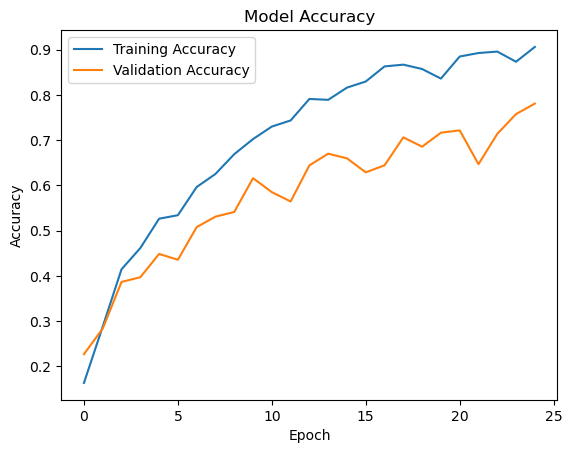

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
def classify_images(image_path):
    # Load the image and resize it to match the model input
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    
    # Convert the image to a numerical array
    input_image_array = tf.keras.utils.img_to_array(input_image)
    
    # Add a new dimension so the model treats it as a batch of 1 image
    input_image_exp_dim = tf.expand_dims(input_image_array, 0)

    # Predict using the trained model
    predictions = model.predict(input_image_exp_dim)
    
    # Convert logits to probabilities
    result = tf.nn.softmax(predictions[0])
    
    # Get the class name with the highest probability and the confidence score
    outcome = 'The Image belongs to ' + animal_names[np.argmax(result)] + \
              ' with a score of ' + str(np.max(result)*100)
    
    return outcome

In [55]:
classify_images('dataset/Bird/Bird_1.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


'The Image belongs to Bird with a score of 100.0'

In [53]:
model.save('Animal_Classification.keras')